# The Fermi-Pasta-Ulam-Tsingou Problem

In [2]:
"""
================================================================
        The Fermi-Pasta-Ulam-Tsingou (FPUT) Problem (1D)
================================================================
"""
from math import log10
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import os

#   Improve performance by applying 'jit' decorator
from numba import jit

__version__ = '1.0'


In [3]:
################################################################################
#                                                                              #
#                            CONSTANTS & PARAMETERS                            #
#                                                                              #
################################################################################
N = 2 ** 6                                      #   Number of masses

ALPHA = 1.0                                     #   Linear spring constant
BETA = 1e-1                                     #   Nonlinear spring constant
# BETA = 0                                        #   No Nonlinear term

t_max = 1e4                                     #   Maximum time
dt_mantissa = 2.5
dt_exp = -2
config_str = f"{int(N)}_{str(ALPHA).replace('.', "d")}_{str(BETA).replace('.', "d")}_{int(log10(t_max))}_{str(dt_mantissa).replace('.', "d")}({int(dt_exp)})"

dt = dt_mantissa * 10 ** dt_exp                 #   Time step
num_steps = int(np.ceil(t_max / dt)) + 1        #   Number of time steps
time_points = np.linspace(0, t_max, num_steps)
y0_amp = 1.0                                    #   Initial displacement amplitude
                                                #   for the first and last points

#   ANIMATION PARAMETERS
if num_steps // (30 * 60) == 0:
    frame_step = 1
else:
    frame_step = num_steps // (150 * 24)      #   To ensure the GIF has 3600 frames


## The Model

Let there be $N$ oscillators representing a string of length $\ell$ with equilibrium positions $r_i = ih$, $i = 0,\dots,~N - 1$, where $h = \frac{\ell}{N - 1}$ is the lattice spacing

Then the position of the $i$-th oscillator as a function of time is $Y_i\left(t\right) = r_i + y_i\left(t\right)$, so that $y_i\left(t\right)$ gives the displacement from equilibrium. FPUT used the following equations of motion:

$$m\ddot{y}_i = \alpha\left(y_{i + 1} + y_{i - 1} - 2y_i\right)\left[1 + \beta\left(y_{i + 1} - y_{i - 1}\right)\right]$$
where for unambiguity, $k = \alpha$

which is just Newton's second law for the $i$-th particle. The first factor $\alpha\left(y_{i + 1} + y_{i - 1} - 2y_i\right)$ is just the usual Hooke's law form for the force. The factor with $\beta$ is the nonlinear force

For all intents and purposes, $m$ is set to unity

Crucially, since this is a 1 dimensional model, we have to decide how we tackle the problem of the boundary particles. There are two approaches -- 1. periodic, and 2. fixed

In [4]:
#   Periodic boundary
@jit
def oneD_periodic(y, v):
    """
    List of ODEs of dvdt following periodic boundary conditions; dydt are all v
    
    :param  y:      numpy array of y values
    :param  v:      numpy array of v values
    
    :return v:      numpy array of dydt values
    :return dvdt:   numpy array of dvdt values
    """
    #   Displaces numpy array to the left and right for computation
    left_neighbors, right_neighbors = np.roll(y, 1), np.roll(y, -1)
    
    dvdt = ALPHA * (left_neighbors + right_neighbors - 2 * y) * (1 + BETA * (right_neighbors - left_neighbors))

    return v, dvdt


In [5]:
#   Fixed boundary
@jit
def oneD_fixed(y, v):
    """
    List of ODEs of dvdt following periodic boundary conditions; dydt are all v
    
    :param  y:      numpy array of y values
    :param  v:      numpy array of v values
    
    :return v:      numpy array of dydt values
    :return dvdt:   numpy array of dvdt values
    """
    dvdt = np.zeros_like(y)             #   Initialize dvdt
    
    #   Interior particles
    dvdt[1:N - 1] = ALPHA * (y[2:N] + y[:N - 2] - 2 * y[1:N - 1]) * (1 + BETA * (y[2:N] - y[:N - 2]))

    #   Boundary particles
    dvdt[0] = ALPHA * (y[1] - 2 * y[0]) * (1 + BETA * y[1])
    dvdt[N - 1] = ALPHA * (y[N - 2] - 2 * y[N - 1]) * (1 + BETA * (- y[N - 2]))

    return v, dvdt


By symmetry, the expression is notably one-dimensional, acting only on the direction perpendicular to the line spanning the equilibrium positions of the oscillators

## ODE Solvers
Consider an ODE of the form:
$$\frac{dy}{dt} = f\left(t,~y\right)$$
where `y` is the dependent variable, and `t` is the independent variable

We adopt two types of ODE Solvers
1. Runge-Kutta 4 Method
2. Euler's Method
### Runge-Kutta 4 Method (RK4)
The Runge-Kutta 4 (RK4) method is a numerical technique used to solve ordinary differential equations (ODEs) of the form:
$$\frac{dy}{dt} = f\left(t,~y\right)$$
where `y` is the dependent variable, and `t` is the independent variable. The RK4 method calculates the solution by taking the weighted average of four increments, where each increment is estimated at different points within the given interval. Here are the steps of the RK4 method:
1. **Calculate the first increment** (`k1`), which is the value of the derivative at the beginning of the interval:
   $$k_1 = f\left(t_n,~y_n\right)$$
2. **Calculate the second increment** (`k2`), which is the value of the derivative at the midpoint of the interval, using `k1` to make an estimate for the midpoint value of `y`:
   $$k_2 = f\left(t_n + \frac{\Delta t}{2},~y_n + \frac{k_1 \cdot \Delta t}{2}\right)$$
3. **Calculate the third increment** (`k3`), again evaluating the derivative at the interval's midpoint but now using `k2` for the estimation:
   $$k_3 = f\left(t_n + \frac{\Delta t}{2},~y_n + \frac{k_2 \cdot \Delta t}{2}\right)$$
4. **Calculate the fourth increment** (`k4`), which is the value of the derivative at the end of the interval, using k3 to estimate the end value of `y`:
   $$k_4 = f\left(t_n + \Delta t,~y_n + k_3 \cdot \Delta t\right)$$
5. **Combine the increments** to produce the final value of `y` at the next time step ($t_{n + 1}$):
   $$y_{n + 1} = y_n + \frac{\Delta t}{6} \left(k_1 + 2k_2 + 2k_3 + k4\right)$$
#### Advantages of RK4
- **Accuracy**: RK4 is a fourth-order method, which means the local truncation error is of the order of $O\left(Δt^5\right)$, while the total accumulated error is of order $O\left(Δt^4\right)$
- **No Higher Derivatives Needed**: Unlike Taylor series methods, RK4 does not require the calculation of higher-order derivatives
- **Widely Used**: It strikes a balance between computational efficiency and accuracy, making it suitable for a wide range of problems
### Euler's Method
Euler's Method is one of the simplest numerical techniques for approximating solutions to ordinary differential equations (ODEs), providing a quick estimate of the solution's behavior. Euler's Method approximates the solution by stepping forward in small increments, $\Delta t$, and using the derivative's value to estimate the slope of the solution curve. The procedure for Euler's method is straightforward:
1. **Start with initial conditions**:
   $$y\left(t_0\right) = y_0$$
2. **Calculate the next value of `y`**:
   $$y_{n + 1} = y_n + f\left(t_n,~y_n\right) \cdot \Delta t$$

   where $y_{n + 1}$ is the estimate of the solution at time $t_{n + 1} = t_n + \Delta t$, $y_n$ is the current value, and $f\left(t_n,~y_n\right)$ is the value of the derivative function at $t_n$
### Advantages and Disadvantages
- **Simplicity**: Euler's Method is conceptually simple and easy to implement
- **Speed**: It is computationally fast because it requires only one function evaluation per step
- **Accuracy and Stability**: It is not very accurate or stable, especially for stiff equations or when a large step size is used. The global error of Euler's method is proportional to the step size, making it a first-order method

In [6]:
#   Runge-Kutta 4th order method
@jit
def rk4_step(y, v, dt, func):
    """
    Runge-Kutta 4th order ODE Solver
    
    :param  y:      numpy array of y values
    :param  v:      numpy array of v values
    :param  dt:     timestep
    :param  func:   ODE expression

    :return y_next: numpy array of successive y values
    :return v_next: numpy array of successive v values
    """
    k1_y, k1_v = func(y, v)
    k2_y, k2_v = func(y + dt / 2 * k1_y, v + dt / 2 * k1_v)
    k3_y, k3_v = func(y + dt / 2 * k2_y, v + dt / 2 * k2_v)
    k4_y, k4_v = func(y + dt * k3_y, v + dt * k3_v)
    
    y_next = y + dt / 6 * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)
    v_next = v + dt / 6 * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)
    
    return y_next, v_next


In [7]:
# Euler's method
@jit
def euler_step(y, v, dt, func):
    """
    Euler step ODE Solver

    :param  y:      numpy array of y values
    :param  v:      numpy array of v values
    :param  dt:     timestep
    :param  func:   ODE expression

    :return y_next: numpy array of successive y values
    :return v_next: numpy array of successive v values
    """
    dy, dv = func(y, v)
    
    y_next = y + dt * dy
    v_next = v + dt * dv

    return y_next, v_next


## Initial conditions

In [8]:
#   Initialized to n modes excitation
def initialize_n_mode(N, mode_no, amp = y0_amp):
    """
    Initialize the system for single mode excitation

    :param  N:      number of particles
    :param  mode_no number of modes
    :param  amp:    excitation amplitude

    :return y:      numpy array of displacements
    :return v:      numpy array of velocities
    """
    n = np.linspace(1, N, N)
    
    y = amp * np.sin(mode_no * np.pi * n / (N + 1))     #   Initialize displacements as
                                                        #   the nth mode sine wave
    v = np.zeros(N)                                     #   Initialize velocities to zero
    
    return y, v


In [9]:
#   Initialized to localized excitation
@jit
def initilize_localized(N, mode_no, amp = y0_amp):
    """
    Initialize the system for localized excitation

    :param  N:      number of particles
    :param  mode_no number of modes
    :param  amp:    excitation amplitude

    :return y:      numpy array of displacements
    :return v:      numpy array of velocities
    """
    #   Initial conditions
    y = np.zeros(N)                 #   Displacements
    v = np.zeros(N)                 #   Velocities
    y[[0, N - 1]] = amp          #   Initial displacements
    
    return y, v


In [10]:
#   Initialized to random excitation
@jit
def initialize_random(N, mode_no, amp = y0_amp):
    """
    Initialize the system for random excitation

    :param  N:      number of particles
    :param  mode_no number of modes
    :param  amp:    excitation amplitude

    :return y:      numpy array of displacements
    :return v:      numpy array of velocities
    """
    # Generate random displacements and velocities
    displacements = np.random.uniform(-amp, amp, N)
    velocities = np.random.uniform(-1.0, 1.0, N)
    
    return displacements, velocities

## Simulation

In [11]:
def simulator(ode_solver, init_func, mode, expression):
    """
    Simulates time evolution of the oscillators

    :param  ode_solver: ODE Solving algorithm
    :param  init_func:  type of initilization
    :param  mode:       number of modes
    :param  expression: ODE expression
    
    :return d:          numpy array of displacements for each timestep
    :return v:          numpy array of velocities for each timestep
    """
    #   Initial conditions
    y, v = init_func(N, mode, 1.0)

    #   Time evolution
    displacements = [y.copy()]      #   2D array of displacements at each time step
    velocities = [v.copy()]         #   2D array of velocities at each time step
    for _ in time_points:
        y, v = ode_solver(y, v, dt, expression)
        displacements.append(y.copy())
        velocities.append(v.copy())

    return np.array(displacements), np.array(velocities)

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

In [12]:
#   Simulate FPUT
displacements_1D_periodic, velocities_1D_periodic = simulator(rk4_step, initialize_n_mode, 2, oneD_periodic)
displacements_1D_fixed, velocities_1D_fixed = simulator(rk4_step, initialize_n_mode, 2, oneD_fixed)


### Saving Data

In [13]:
def save_subset(filename, data):
    """
    Save data subset (corresponding to the gif)
    """
    subset = data[:, int(np.ceil(N / 2))]
    np.savetxt(f'./subset_data/{filename}_{config_str}.txt', subset)

    return None


In [14]:
#   Create subfolders if missing
os.makedirs(f'./{config_str}', exist_ok = True)
os.makedirs('./subset_data', exist_ok = True)
os.makedirs('./subset_data/time_points', exist_ok = True)

# #   Save complete numpy dump file
# np.savetxt(f'./{config_str}/displacements_1D_periodic_{config_str}.txt', displacements_1D_periodic)
# np.savetxt(f'./{config_str}/velocities_1D_periodic_{config_str}.txt', velocities_1D_periodic)
# np.savetxt(f'./{config_str}/displacements_1D_fixed_{config_str}.txt', displacements_1D_fixed)
# np.savetxt(f'./{config_str}/velocities_1D_fixed_{config_str}.txt', velocities_1D_fixed)

# #   Save time points
# np.savetxt(f'./subset_data/time_points/{config_str}.txt', time_points)


In [15]:
# #   Save subset numpy dump file
# save_subset('displacements_1D_periodic', displacements_1D_fixed)
# save_subset('displacements_1D_fixed', displacements_1D_periodic)
# save_subset('velocities_1D_periodic', velocities_1D_periodic)
# save_subset('velocities_1D_fixed', velocities_1D_fixed)


## Animation

In [16]:
def gif_plotter(filename, displacements):
    """
    GIF Plotter function v2.0

    Plots GIF visualizing time evolution of vertical displacements
    """
    fig, ax = plt.subplots()
    line, = ax.plot(displacements[0, :], marker = '.', c = 'b')      #    Initial plot of displacement v.s. particle number

    #   Gridlines
    ax.axhline(y = 0, c = '#d3d3d3', lw = 0.5, ls = '-')
    ax.axvline(x = len(displacements[0]) - 1, c = '#d3d3d3', lw = 0.5, ls = '-')
    ax.axvline(x = 0, c = '#d3d3d3', lw = 0.5, ls = '-')

    #   Set plot limits and labels
    ax.set_ylim(- y0_amp, y0_amp)
    ax.set_xlabel(r'$n^{\text{th}}$ Particle')
    ax.set_ylabel('Displacement (units)')
    title = ax.set_title(f'Time: {0:.3f} units')
    fig.suptitle(f'{filename} ({N} particles)')

    #   Update the y-data of the plot to show the displacements at the current time step
    def update(frame):
        line.set_ydata(displacements[frame, :])             #    Successive plot of displacement v.s. particle number
        title.set_text(f'Time: {frame * dt:.2f} units')     #    Update elapsed time in title
        return line, title

    #   Creates and saves animation
    ani = FuncAnimation(fig, update, frames = range(0, num_steps, frame_step), blit = True)
    ani.save(f'./{config_str}/{filename}_{config_str}.mp4', writer = 'ffmpeg', fps = 24)

    #   Close the plot
    plt.close()
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

In [17]:
#   Plot animations
gif_plotter('displacements_1D_periodic', displacements_1D_periodic)
gif_plotter('displacements_1D_fixed', displacements_1D_fixed)


## Total Energy

In [26]:
#   Calculates total potential energy at each time step
def potential_energy(displacements):
    """
    Calculates potential energy of the system at each time step

    :param  displacements:  numpy array of displacements at each time step

    :return total_pe:       numpy array of total potential energy at each time step
    """
    delta_x = displacements - np.roll(displacements, -1, axis = 1)

    pe_linear = 0.5 * ALPHA * (delta_x ** 2)
    pe_nonlinear = (1/3) * BETA * (delta_x ** 3)

    total_pe_linear = np.sum(pe_linear, axis = 1)
    total_pe_nonlinear = np.sum(pe_nonlinear, axis = 1)

    total_pe = total_pe_linear + total_pe_nonlinear

    return total_pe

In [27]:
#   Calculates total kinetic energy at each time step
def kinetic_energy(velocities):
    """
    Calculates kinetic energy of the system at each time step

    :param  velocities:     numpy array of velocities at each time step

    :return total_ke:       numpy array of total kinetic energy at each time step
    """
    ke = 0.5 * (velocities ** 2)

    total_ke = np.sum(ke, axis = 1)

    return total_ke

In [43]:
def total_energy_plotter(filename, displacements, velocities):
    """
    Total energy plotter function

    Plot graph visualizing total energy over time
    """
    plt.stackplot(time_points, potential_energy(displacements[:-1]), kinetic_energy(velocities[:-1]), labels = ['Potential Energy', 'Kinetic Energy'])

    #   Set plot limits and labels
    plt.grid(True)
    plt.xlabel('Time (units)')
    plt.ylabel('Total Energy')
    plt.title('Total Energy in the system over Time')
    plt.legend()

    #   Saves plot
    plt.savefig(f'./{config_str}/{filename}_{config_str}_energy_modes.png', transparent = True)

    #   Show & close the plot
    plt.show()
    plt.close()
    return None

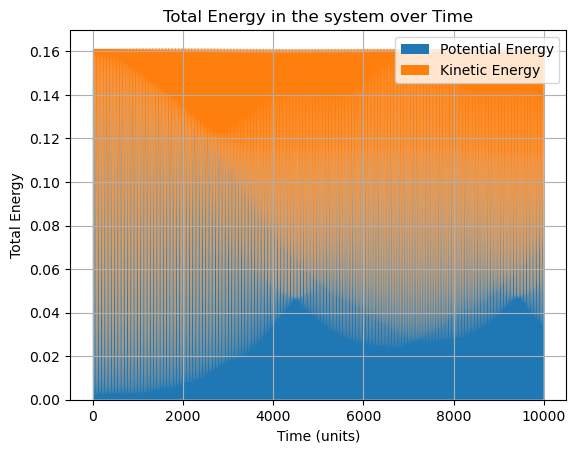

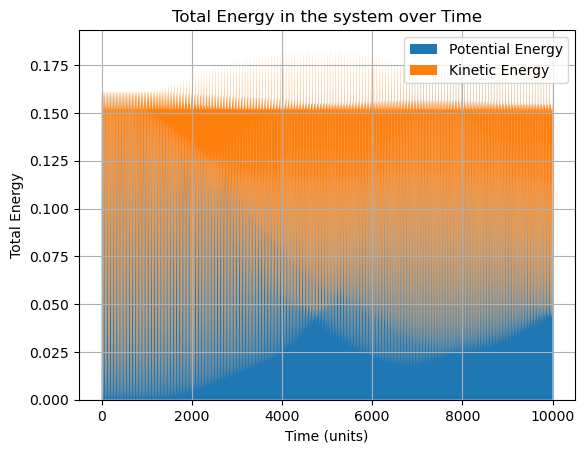

In [44]:
total_energy_plotter('1D_periodic', displacements_1D_periodic, velocities_1D_periodic)
total_energy_plotter('1D_fixed', displacements_1D_fixed, velocities_1D_fixed)

## Mode Energy Analysis

In [30]:
def fft_plotter(filename, displacements):
    """
    FFT plotter function

    Plot graph visualizing energy distribution across modes
    """
    # Fourier Transform of Displacements to show energy distribution across FFT modes
    fourier_transform = np.fft.rfft(displacements[:-1], axis = 1)
    mode_energies = np.abs(fourier_transform) ** 2

    plt.figure(figsize = (12, 5))
    for i in range(1, 5):  # First four modes after the zero mode
        plt.plot(time_points, mode_energies[:, i], lw = 0.5, label = f'Mode {i}')

    #   Set plot limits and labels
    plt.grid(True)
    plt.xlabel('Time (units)')
    plt.ylabel('Mode Energy')
    plt.title('Energy in the First Four Modes Over Time')
    plt.suptitle(f'{filename} ({N} particles)')
    plt.legend()

    #   Saves plot
    plt.savefig(f'./{config_str}/{filename}_{config_str}_energy_modes.png', transparent = True)

    #   Show & close the plot
    plt.show()
    plt.close()
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

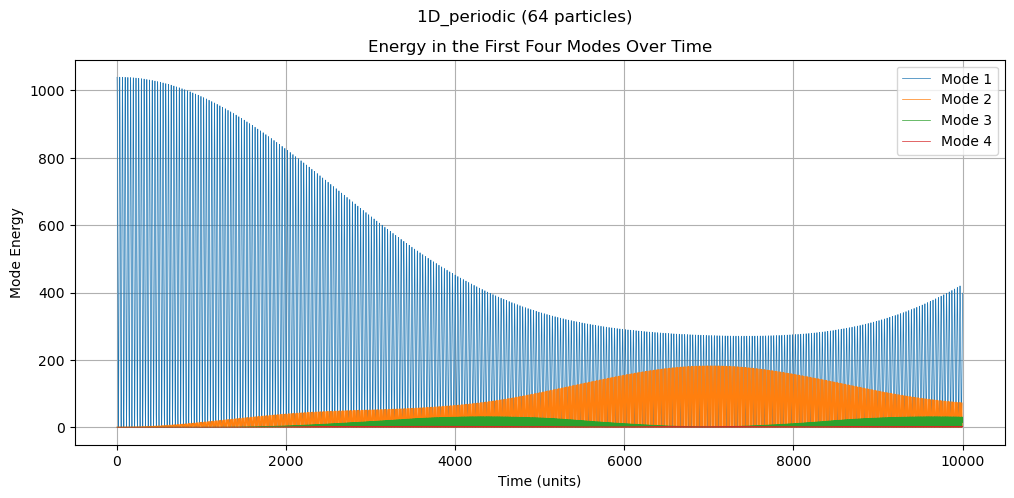

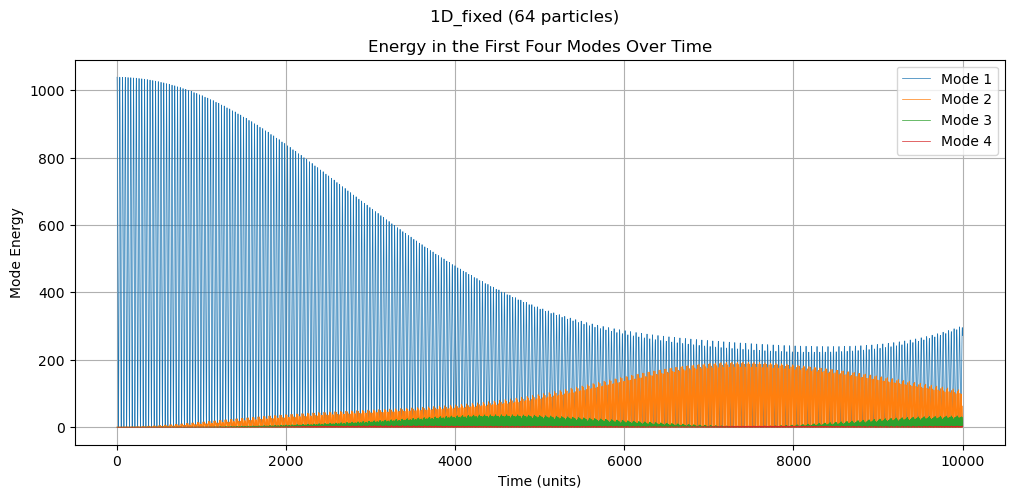

In [31]:
#   Plot FFT
fft_plotter('1D_periodic', displacements_1D_periodic)
fft_plotter('1D_fixed', displacements_1D_fixed)


## Temperature Evolution
$$\left\langle E_{\operatorname{k}}\right\rangle = \frac{1}{2}m\left\langle v^2\right\rangle = \frac{1}{2}k_{\operatorname{B}}T$$
$$T \propto\left\langle v^2\right\rangle$$

In [32]:
def temperature_evolution(filename, velocities):
    """
    Temperature Evolution plotter function

    Plots system 'temperature' against time
    """
    temperature = np.mean(velocities ** 2, axis = 1)
    
    plt.figure(figsize = (12, 5))
    plt.plot(time_points, temperature[:-1], c = 'b', lw = 0.5, ls = '-')

    #   Set plot limits and labels
    plt.grid(True)
    plt.xlabel('Time (units)')
    plt.ylabel('Temperature (units)')
    plt.title(f'Temperature Evolution of the system over time')
    plt.suptitle(f'{filename} ({N} particles)')

    #   Saves plot
    plt.savefig(f'./{config_str}/{filename}_{config_str}_temperature_evolution.png', transparent = True)

    #   Show & close the plot
    plt.show()
    plt.close()
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

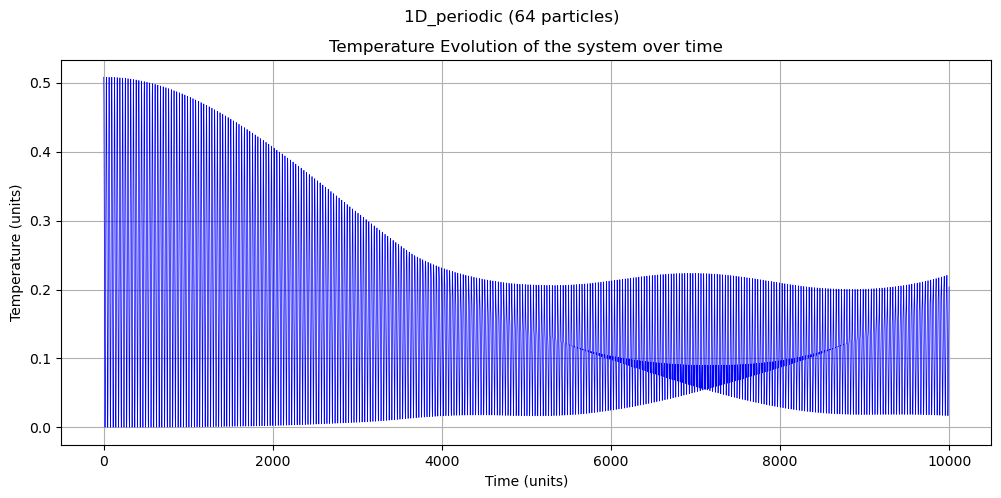

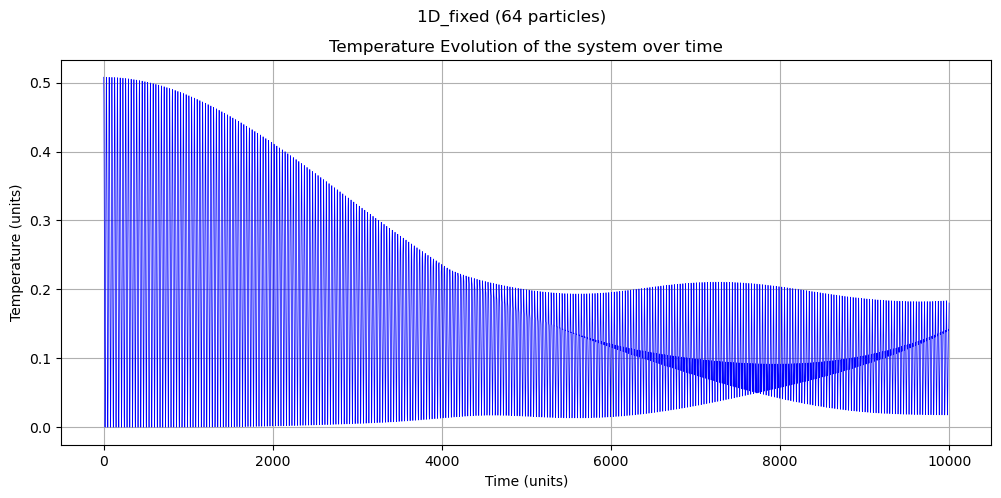

In [33]:
#   Plot temperature evolution
temperature_evolution('1D_periodic', displacements_1D_periodic)
temperature_evolution('1D_fixed', displacements_1D_fixed)


## Phase Space Dynamics

In [36]:
## ~~Phase Space Trajectories~~
def phase_space_plotter(filename, displacements, velocities):
    """
    Phase space plotter function

    Plots velocity against displacement in a phase space plot
    """
    particle_index = int(np.ceil(N / 2))

    plt.figure(figsize = (12, 5))
    plt.scatter(displacements[:-1, particle_index], velocities[:-1, particle_index], c = time_points, cmap = 'viridis', s = 10, lw = 0, ls = '-')

    #   Set plot limits and labels
    plt.colorbar(label = 'Time')
    plt.grid(True)
    plt.xlabel('Displacement (units)')
    plt.ylabel('Velocity (units)')
    plt.title(f'Phase Space Trajectory for Particle {particle_index}')
    plt.suptitle(f'{filename} ({N} particles)')
    plt.legend()

    #   Saves plot
    plt.savefig(f'./{config_str}/{filename}_{config_str}_phase_space.png', transparent = True)

    #   Show & close the plot
    plt.show()
    plt.close()
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


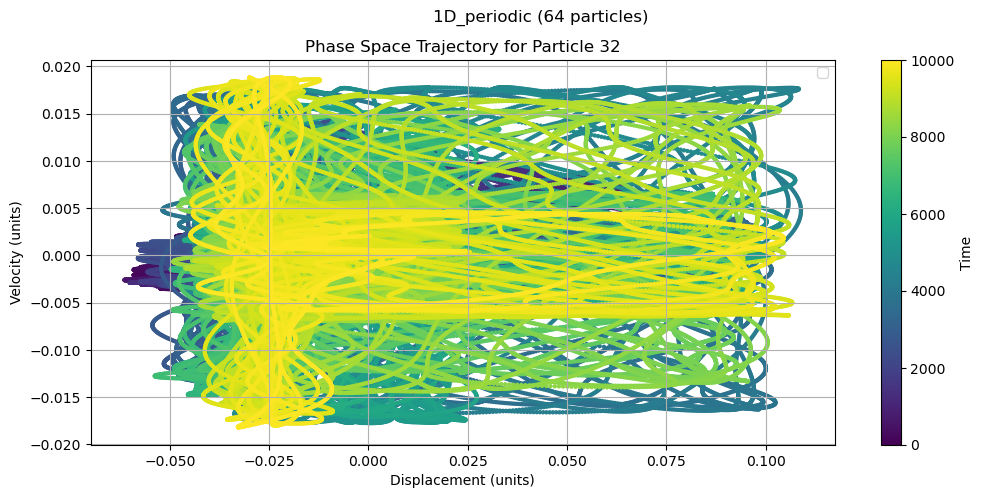

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


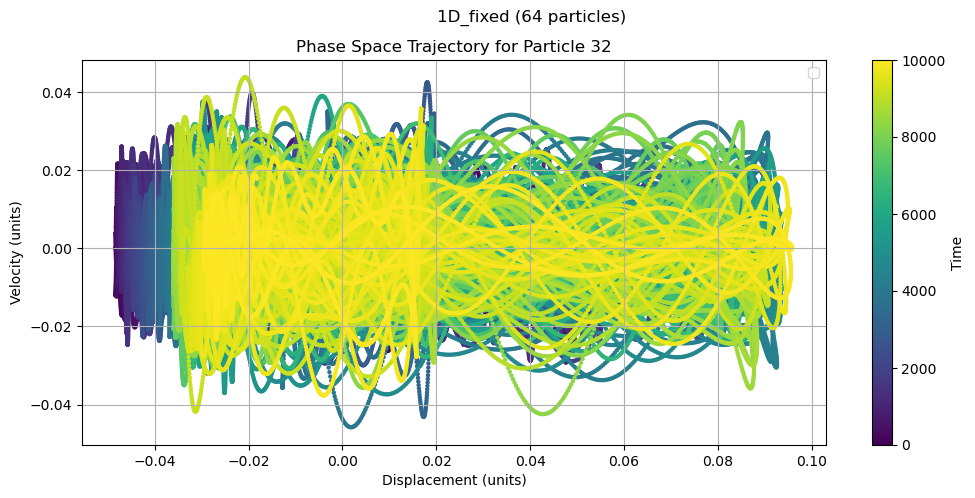

In [37]:
#   Plot phase space trajectories
phase_space_plotter('1D_periodic', displacements_1D_periodic, velocities_1D_fixed)
phase_space_plotter('1D_fixed', displacements_1D_fixed, velocities_1D_periodic)


## Lyapunov Exponent

In [42]:
# import nolds

# lyap_exp_periodic = nolds.lyap_e(velocities_1D_periodic, emb_dim = 10, matrix_dim = 2)
# print("Largest Lyapunov Exponent (Periodic):", lyap_exp_periodic)

# lyap_exp_fixed = nolds.lyap_e(velocities_1D_fixed, emb_dim = 10, matrix_dim = 2)
# print("Largest Lyapunov Exponent (Fixed):", lyap_exp_fixed)


KeyboardInterrupt: 

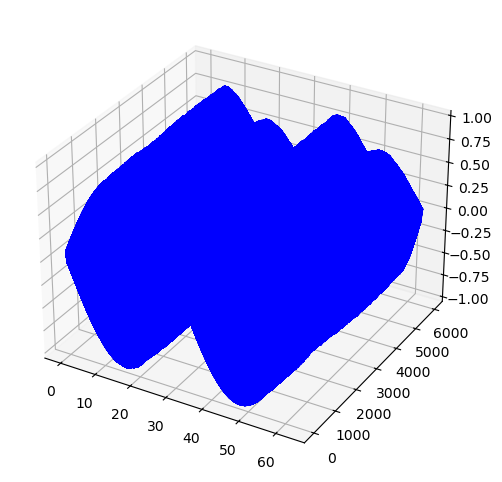

In [41]:
# Preparing the figure and 3D axes
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111, projection='3d')

# Waterfall plot: plot lines for each timestep
for i, t in enumerate(time_points[0:num_steps:frame_step]):
    # Offset each line plot along the z-axis by the current time step
    ax.scatter(np.arange(N), displacements_1D_periodic[i, :], zs = t, zdir = 'y', marker = '.', color = 'b')

# Labels and titles
ax.set_xlabel('Particle Index')
ax.set_ylabel('Time')
ax.set_zlabel('Displacement')

# Set the angle of the view
ax.view_init(30, -60)  # Elevation and azimuth

plt.title('Waterfall Plot of Particle Displacements Over Time')
plt.show()